In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
path_raw = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/raw/'

In [3]:
caratteristiche = pd.read_excel(path_raw+'caratteristiche.xlsx')
costi = pd.read_excel(path_raw+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_raw+'efficienza_energetica.xlsx')

In [ ]:
caratteristiche.info()

In [ ]:
costi.info()

In [ ]:
efficienza_energetica.info()

In [4]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

### Join all three tables and start looking into the data

In [5]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [ ]:
df.loc[df['prezzo'] == 'Prezzo su richiesta', :].shape

In [ ]:
df.info()

In [6]:
# Rename columns
df.columns = map(str.capitalize, df.columns)

In [7]:
# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

In [ ]:
df.loc[df['Zona'].isna(), :]

In [8]:
# Clean up data types
df['Superficie [m2]'] = (df['Superficie']
                         .str.split('m²')
                         .str[0]
                         .astype('float'))

df['Totale piani edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0]
                               .astype('float'))

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

df['Prezzo [EUR]'] = (df['Prezzo']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [ ]:
df['Prezzo [EUR]'].mean()

In [9]:
# Drop entries without area
df = df.dropna(subset=['Superficie [m2]'])

In [ ]:
# Looking into "Contratto": does it affect price?
gb = df['Prezzo [EUR]'].groupby(df['Contratto']).agg('mean')
gb

In [ ]:
# Drop columns that have almost no entries
# Dropping because of lack of entries
# Dropping "Disponibilità" and "Contratto" because it is not relevant information
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica',
                      'Disponibilità', 'Contratto'])


In [ ]:
df.info()

### Feature engineering

#### Heating

In [ ]:
df['Riscaldamento'].unique()

In [10]:
# Create type of heating feature
df['Tipologia di riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

#### Listing date

In [ ]:
df['Riferimento e data annuncio'].head(100)

In [11]:
df['Data annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Floor

In [ ]:
df['Piano'].unique()

In [12]:
mask = df['Piano'].str.match(r'(.*ascensore.*)')

df['Ascensore'] = mask.astype('float')

In [ ]:
df['Totale piani edificio'].isna().sum()

In [ ]:
df['Altre caratteristiche'].str.replace('\n', ';')
df['Altre caratteristiche'].unique()[10]

In [ ]:
df['Stato'].value_counts()

#### Number of rooms and toilets

In [ ]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [13]:
# TO FLOAT? 3+
df['Numero di bagni'] = (df['Locali']
                         .str.findall(r'(\d\+? bagn\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0])

df.loc[df['Numero di bagni'].isna(), 'Numero di bagni'] = 0
df.loc[df['Numero di bagni'] == '3+', 'Numero di bagni'] = 4
df['Numero di bagni'] = df['Numero di bagni'].astype('float')

In [ ]:
df['Numero di bagni'].value_counts()

In [ ]:
sns.barplot(x=df['Numero di bagni'].value_counts().index, y=df['Numero di bagni'].value_counts())

In [ ]:
df.loc[df['Numero di bagni'] == 0, 'Superficie [m2]']

In [14]:
df['Superficie_Bins'] = pd.cut(df['Superficie [m2]'], bins=[0, 60, 80, 100, 120, 160, 200, 10000])


In [ ]:
df['Superficie_Bins'].unique()

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero di bagni'])
plt.xticks(rotation=45)

In [ ]:
df.groupby(['Superficie_Bins'])['Numero di bagni'].agg(lambda x:x.value_counts().index[0])

In [15]:
# Imputing number of toilets based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero di bagni'] == 0), 'Numero di bagni'] = df.loc[mask, 'Numero di bagni'].mode().values


In [16]:
df['Numero di altri'] = (df['Locali']
                         .str.findall(r'(\d?\d\+? altr\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                         .astype('float'))
df.loc[df['Numero di altri'].isna(), 'Numero di altri'] = 0

In [17]:
df['Numero di camere da letto'] = (df['Locali']
                                   .str.findall(r'(\d?\d\+? camer\w da letto)')
                                   .str[0]
                                   .str.split(' ')
                                   .str[0]
                                   .astype('float'))
df.loc[df['Numero di camere da letto'].isna(), 'Numero di camere da letto'] = 0

In [18]:
df['Numero di locali'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? local\w)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))
df.loc[df['Numero di locali'].isna(), 'Numero di locali'] = 0

In [19]:
df['Numero totale di locali'] = df['Numero di locali'] + df['Numero di camere da letto'] + df['Numero di altri']

In [ ]:
df['Numero totale di locali'].isna().sum()

In [ ]:
df.loc[df['Locali'].isna(), :].shape

In [ ]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero totale di locali'])
plt.xticks(rotation=45)

In [20]:
# Imputing number of rooms based on area bins
for area in df['Superficie_Bins'].unique():
    mask = df['Superficie_Bins'] == area
    df.loc[mask & (df['Numero totale di locali'] == 0),
           'Numero totale di locali'] = df.loc[mask, 'Numero totale di locali'].mode().values

In [ ]:
df.loc[mask & (df['Numero totale di locali'] == 0), 'Numero totale di locali']

In [ ]:
df.loc[df['Numero totale di locali'].isna(), :].shape

In [ ]:
df.info()

In [21]:
df_final = df[['Data annuncio', 'Zona', 'Prezzo [EUR]', 'Tipologia', 'Superficie [m2]',
               'Numero totale di locali', 'Numero di bagni', 'Stato', 'Tipologia di riscaldamento']]

In [22]:
df_final = df_final.dropna(subset=['Prezzo [EUR]'])

In [ ]:
df_final.loc[df_final['Prezzo [EUR]'].isna(), :]

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8743 entries, 0 to 9062
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Data annuncio               8743 non-null   datetime64[ns]
 1   Zona                        8683 non-null   object        
 2   Prezzo [EUR]                8743 non-null   float64       
 3   Tipologia                   8743 non-null   object        
 4   Superficie [m2]             8743 non-null   float64       
 5   Numero totale di locali     8743 non-null   float64       
 6   Numero di bagni             8743 non-null   float64       
 7   Stato                       8743 non-null   object        
 8   Tipologia di riscaldamento  8346 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 683.0+ KB


In [ ]:
# Dropping N/A values


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

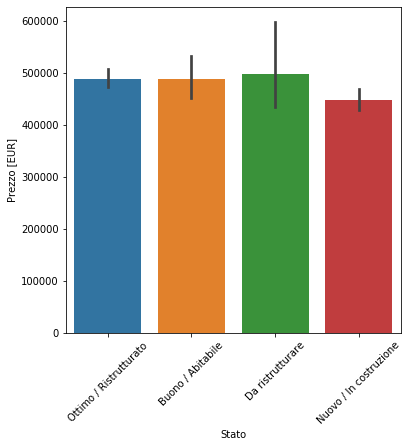

In [27]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Stato'], y=df['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [32]:
# Imputing "Stato" by most frequent as it does not seem to influence price much
df_final['Stato'] = df_final['Stato'].fillna(df_final['Stato'].value_counts().index[0])

(array([0, 1]), <a list of 2 Text xticklabel objects>)

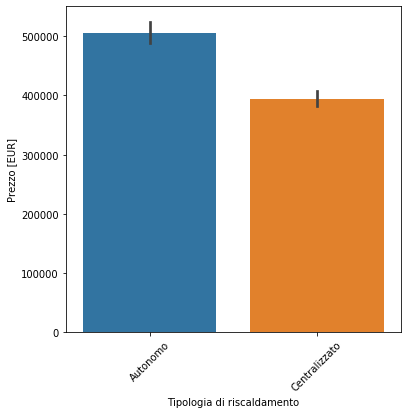

In [34]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Tipologia di riscaldamento'], y=df['Prezzo [EUR]'])
plt.xticks(rotation=45)

In [ ]:
# Area [m2] distribution
fig = plt.figure(figsize=(10, 10))
sns.distplot(df['Superficie [m2]'], kde=False)